In [15]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

In [17]:
from numba.typed import List
from numba import jit, njit, vectorize

In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [19]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [20]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 
@njit()
def get_rng(x):
    n = np.max(x)
    m = np.min(x)
    z = n-m
    return z 

def get_rms(x, axis=None):
    return np.sqrt(np.mean(x ** 2, axis=axis))

def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])

def get_sma(data): 
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return sma_sim, sma_adv, sma_sim_abs, sma_adv_abs

def get_entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

In [21]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

# Feature extraction

In [22]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    features = []
    signal = np.array(win, dtype=float)
    fourier = np.fft.fft(signal) # FFT
    N = len(fourier)//2+1
    real_fft = np.abs(fourier[:N]) # real value of FFT
    n = signal.size
    timestep = 0.02 # Sample spacing (inverse of the sampling rate).
    freq = np.fft.fftfreq(n, d=timestep) # FREQUENCY DATA
    fft_ps = np.abs(fourier)**2 # POWER SPECTRUM
    ps = np.sum(fft_ps)
    energy_measure = Energy(fft_ps) #Get the energy using Parseval's theorem
    fft_magnitude = np.sum((np.abs (fourier [: N ]))/N)   # signal magnitude which is the normalized value of the FFT coefficients
    
    features.append((ps))
    features.append(energy_measure)
    features.append(fft_magnitude)
    features.append(get_mean(freq))
    features.append(get_min(freq))
    features.append(get_max(freq))
   
    #features = np.array(features)
    features = np.hstack(features).tolist()
    
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [23]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [24]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []
    ALL = []

    for subject in range(1,18):
        file_path = dataset_path + '/subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        all_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
        for i in range(2, 117, 13):# indices of all
            indices = list(range(i, i + 13))
            all_cols.extend(indices)

        all_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=all_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ALL.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ALL_dataset = pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    ALL_dataset = ACC_dataset.append(ALL, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset,ALL_dataset
   

In [25]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [26]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1].values
    Y = dataset.iloc[:, -1].values
   

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    
    return accuracy

In [27]:
mod = {'RF': RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)}

In [ ]:
%%time
dataset_csv_path = r"./data_csv"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD,ALL = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

In [ ]:
%%time
ACC.head(10)

In [ ]:
%%time
GYR.head(10)

Wall time: 1 ms


,group,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,1,42874.983817,55.907201,75.761477,288.791466,225.895452,73.119487,75.219548,153.669823,167.707934,...,75.219548,73.119487,225.895452,288.791466,75.761477,81.768314,-0.006173,-25.0,24.987654,1
1,1,44607.230029,75.331439,89.207318,279.416200,168.634230,85.986266,77.188755,315.374910,227.276791,...,77.188755,85.986266,168.634230,279.416200,89.207318,73.742121,-0.006173,-25.0,24.987654,1
2,1,42843.122731,92.163644,80.775253,232.213284,148.256372,79.768136,85.449442,309.641084,195.032899,...,85.449442,79.768136,148.256372,232.213284,80.775253,70.297998,-0.006173,-25.0,24.987654,1
3,1,49187.729723,180.279611,99.205575,283.108543,507.901413,150.625498,99.059119,329.738474,223.964854,...,99.059119,150.625498,507.901413,283.108543,99.205575,81.718199,-0.006173,-25.0,24.987654,1
4,1,53812.279907,171.835720,233.727482,275.116048,501.710010,159.668558,96.894540,331.039439,346.536485,...,96.894540,159.668558,501.710010,275.116048,233.727482,76.649290,-0.006173,-25.0,24.987654,1
5,1,60055.042993,153.808242,448.238599,358.172468,1079.190479,161.507750,525.382461,276.292963,528.290117,...,525.382461,161.507750,1079.190479,358.172468,448.238599,75.106748,-0.006173,-25.0,24.987654,1
6,1,72960.293970,193.837638,1092.491498,401.179577,1427.843980,197.842880,725.649425,717.753664,585.897097,...,725.649425,197.842880,1427.843980,401.179577,1092.491498,85.497050,-0.006173,-25.0,24.987654,1
7,1,87805.852637,436.071410,1160.678011,573.063797,1465.543034,469.463221,1964.132794,962.775505,725.488012,...,1964.132794,469.463221,1465.543034,573.063797,1160.678011,84.932202,-0.006173,-25.0,24.987654,1
8,1,95468.598812,1298.931162,1492.530117,975.937010,1480.961138,585.882642,2283.276982,1280.378393,737.863101,...,2283.276982,585.882642,1480.961138,975.937010,1492.530117,86.389040,-0.006173,-25.0,24.987654,1
9,1,104064.724774,1460.988987,1554.789010,1549.210886,1617.869170,606.992506,2334.643090,1369.890521,755.707582,...,2334.643090,606.992506,1617.869170,1549.210886,1554.789010,96.472059,-0.006173,-25.0,24.987654,1


In [ ]:
%%time
MAG.head(10)

Wall time: 1 ms


,group,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,1,15470.307672,127.811230,12.484777,4.542180,17.889980,0.310209,3.200969,0.997149,34.342839,...,3.200969,0.310209,17.889980,4.542180,12.484777,43.498994,-0.006173,-25.0,24.987654,1
1,1,15432.759952,128.719444,13.442847,4.703550,18.855249,0.395778,2.675942,1.084419,33.597210,...,2.675942,0.395778,18.855249,4.703550,13.442847,43.421234,-0.006173,-25.0,24.987654,1
2,1,15511.383208,128.089601,13.429704,5.480694,20.139436,0.403777,2.450744,1.581433,31.428353,...,2.450744,0.403777,20.139436,5.480694,13.429704,44.024521,-0.006173,-25.0,24.987654,1
3,1,15615.345049,134.667306,12.152155,5.260885,20.932121,0.378073,2.969923,1.553449,32.251437,...,2.969923,0.378073,20.932121,5.260885,12.152155,44.081865,-0.006173,-25.0,24.987654,1
4,1,15907.534049,133.708814,8.938848,5.301033,19.204642,0.373306,6.217127,1.559872,35.243151,...,6.217127,0.373306,19.204642,5.301033,8.938848,44.262543,-0.006173,-25.0,24.987654,1
5,1,16552.147935,215.596099,8.658834,5.661015,16.757182,0.983545,6.873223,1.366379,35.394156,...,6.873223,0.983545,16.757182,5.661015,8.658834,44.403985,-0.006173,-25.0,24.987654,1
6,1,17272.919744,348.045638,12.387008,5.125326,14.269588,2.555038,6.559565,1.082457,33.512375,...,6.559565,2.555038,14.269588,5.125326,12.387008,44.234918,-0.006173,-25.0,24.987654,1
7,1,17855.677315,385.020470,24.640892,4.840409,11.714349,3.301816,6.088135,1.259210,30.220790,...,6.088135,3.301816,11.714349,4.840409,24.640892,44.104962,-0.006173,-25.0,24.987654,1
8,1,19157.120680,601.671761,29.629917,4.667194,10.545487,3.395046,5.568319,1.411009,25.402648,...,5.568319,3.395046,10.545487,4.667194,29.629917,44.416300,-0.006173,-25.0,24.987654,1
9,1,20519.822764,707.474518,29.726880,3.973492,9.641105,3.442311,5.377035,2.111914,20.562308,...,5.377035,3.442311,9.641105,3.973492,29.726880,45.426815,-0.006173,-25.0,24.987654,1


In [ ]:
%%time
QUAD.head(10)

Wall time: 997 µs


,group,0,1,2,3,4,5,6,7,8,...,32,33,34,35,36,37,38,39,40,41
0,1,48599.995162,1775.366894,56.267102,1.788897,68.848498,11.059667,6.001489,284.452981,160.420777,...,6.001489,11.059667,68.848498,1.788897,56.267102,94.054425,-0.00463,-25.0,24.990741,1
1,1,48599.997282,1695.707904,51.566299,1.314742,69.928250,10.080975,6.931259,273.279559,156.606493,...,6.931259,10.080975,69.928250,1.314742,51.566299,93.923667,-0.00463,-25.0,24.990741,1
2,1,48599.993082,1618.572557,54.062791,1.413804,64.827036,11.499158,6.459805,263.542942,148.239479,...,6.459805,11.499158,64.827036,1.413804,54.062791,93.815334,-0.00463,-25.0,24.990741,1
3,1,48599.996126,1672.652569,62.799546,1.946292,56.587453,12.548474,5.486511,266.187329,144.476936,...,5.486511,12.548474,56.587453,1.946292,62.799546,93.557217,-0.00463,-25.0,24.990741,1
4,1,48600.001053,1673.196439,67.422352,2.208714,54.600066,11.688400,4.879299,271.553777,156.684198,...,4.879299,11.688400,54.600066,2.208714,67.422352,93.463172,-0.00463,-25.0,24.990741,1
5,1,48600.004131,1617.778460,64.348474,2.191858,51.415823,10.522011,7.049439,271.918021,172.370299,...,7.049439,10.522011,51.415823,2.191858,64.348474,93.852371,-0.00463,-25.0,24.990741,1
6,1,48600.000683,1539.654786,58.844674,1.950658,47.369155,9.576717,8.711195,262.803240,182.947065,...,8.711195,9.576717,47.369155,1.950658,58.844674,93.835725,-0.00463,-25.0,24.990741,1
7,1,48600.008680,1372.766899,52.934099,1.580957,45.488970,8.094219,8.865833,245.222893,188.168121,...,8.865833,8.094219,45.488970,1.580957,52.934099,93.796969,-0.00463,-25.0,24.990741,1
8,1,48600.011565,1250.420480,50.594057,1.874329,37.857265,7.959638,8.524500,230.102896,186.434876,...,8.524500,7.959638,37.857265,1.874329,50.594057,93.789042,-0.00463,-25.0,24.990741,1
9,1,48600.009000,1228.740662,51.186261,1.952045,32.174557,7.910693,7.860139,217.685027,186.461034,...,7.860139,7.910693,32.174557,1.952045,51.186261,93.869053,-0.00463,-25.0,24.990741,1


In [ ]:
%%time
ALL = ALL.fillna(0)
ALL.head(10)

Wall time: 330 ms


,group,0,1,2,3,4,5,6,7,8,...,113,114,115,116,117,118,119,120,121,122
0,1,3.712174e+06,5.193555e+06,1.740326e+06,924020.488472,164004.025475,30878.257128,4662.451773,9754.922325,169041.447627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3.713195e+06,5.264197e+06,1.874674e+06,896268.070794,172038.569687,31618.756486,4949.132278,9815.723141,168056.203994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3.748003e+06,5.566033e+06,1.973134e+06,925774.547462,191948.625760,32435.445813,5505.081630,9905.987871,181392.616568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3.703585e+06,6.371095e+06,1.739192e+06,850986.380059,189552.336943,32600.895418,5836.079115,8994.837076,166735.300300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3.715094e+06,7.187842e+06,1.482979e+06,775082.264280,183798.755021,49898.701850,10897.375194,17877.226962,170064.437068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,3.811718e+06,1.118630e+07,1.214111e+06,738502.753640,151908.675272,52282.683685,13208.987985,45147.198156,179801.926687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,3.783667e+06,1.425380e+07,1.088595e+06,584769.112668,126271.909707,49604.076690,11839.670115,45087.195120,161495.409032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,3.848213e+06,2.078998e+07,9.823078e+05,498496.579216,116902.839389,57377.323394,15772.416081,60350.914334,167107.814719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,3.929202e+06,2.683234e+07,8.954506e+05,431384.888106,92971.162382,50502.502880,19027.830819,85414.854641,162139.716487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,3.893862e+06,3.301413e+07,6.374723e+05,353509.743395,86779.510581,54045.427211,24099.152046,104118.639134,140236.677664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
%%time
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.7538461538461538
Model- 2  -  f1 score:  0.8286922805780754
Model- 3  -  f1 score:  0.7312
Model- 4  -  f1 score:  0.8402937127122533
Model- 5  -  f1 score:  0.5862068965517241
Model- 6  -  f1 score:  0.7911111111111111
Model- 7  -  f1 score:  0.8781163434903049
Model- 8  -  f1 score:  0.7154377880184332
Model- 9  -  f1 score:  0.5716239316239317
Model- 10  -  f1 score:  0.8060771594400821
Model- 11  -  f1 score:  0.680625
Model- 12  -  f1 score:  0.7898869346733668
Model- 13  -  f1 score:  0.532881738639571
Model- 14  -  f1 score:  0.6117564237944386
Model- 15  -  f1 score:  0.7423126894759637
Model- 16  -  f1 score:  0.6179693206720234
Model- 17  -  f1 score:  0.7850893875998478
Wall time: 2min 11s


0.7213604042486635

In [ ]:
%%time
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.6972027972027972
Model- 2  -  f1 score:  0.7948537187169544
Model- 3  -  f1 score:  0.7336
Model- 4  -  f1 score:  0.778797613584213
Model- 5  -  f1 score:  0.6589655172413793
Model- 6  -  f1 score:  0.7833333333333333
Model- 7  -  f1 score:  0.2409972299168975
Model- 8  -  f1 score:  0.7158218125960061
Model- 9  -  f1 score:  0.5842735042735042
Model- 10  -  f1 score:  0.8187094571526118
Model- 11  -  f1 score:  0.6759375
Model- 12  -  f1 score:  0.8332286432160804
Model- 13  -  f1 score:  0.4036127575500988
Model- 14  -  f1 score:  0.7208729320661739
Model- 15  -  f1 score:  0.8501515807708965
Model- 16  -  f1 score:  0.6617969320672024
Model- 17  -  f1 score:  0.8029669075694181
Wall time: 2min 7s


0.6914777786622098

In [ ]:
%%time
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.3472027972027972
Model- 2  -  f1 score:  0.5512865703207613
Model- 3  -  f1 score:  0.5704
Model- 4  -  f1 score:  0.7879761358421294
Model- 5  -  f1 score:  0.5110344827586207
Model- 6  -  f1 score:  0.6277777777777778
Model- 7  -  f1 score:  0.9833795013850416
Model- 8  -  f1 score:  0.7534562211981567
Model- 9  -  f1 score:  0.6331623931623932
Model- 10  -  f1 score:  0.6592693752133834
Model- 11  -  f1 score:  0.69625
Model- 12  -  f1 score:  0.7273869346733667
Model- 13  -  f1 score:  0.47981936212249504
Model- 14  -  f1 score:  0.5269271383315733
Model- 15  -  f1 score:  0.5660459073191858
Model- 16  -  f1 score:  0.512417823228634
Model- 17  -  f1 score:  0.6603271205781666
Wall time: 2min 10s


0.623183502418499

In [ ]:
%%time
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.12097902097902098
Model- 2  -  f1 score:  0.37433909058865
Model- 3  -  f1 score:  0.2628
Model- 4  -  f1 score:  0.1564938044974759
Model- 5  -  f1 score:  0.38413793103448274
Model- 6  -  f1 score:  0.42277777777777775
Model- 7  -  f1 score:  0.5069252077562327
Model- 8  -  f1 score:  0.15130568356374807
Model- 9  -  f1 score:  0.15623931623931625
Model- 10  -  f1 score:  0.11847046773642882
Model- 11  -  f1 score:  0.47125
Model- 12  -  f1 score:  0.11871859296482412
Model- 13  -  f1 score:  0.11402766017499294
Model- 14  -  f1 score:  0.0725096796902499
Model- 15  -  f1 score:  0.4469467301862278
Model- 16  -  f1 score:  0.4802775748721695
Model- 17  -  f1 score:  0.08824648155192089
Wall time: 2min 42s


0.2615555893890305

In [ ]:
%%time
print('ALL_accuracy = ', )
ALL_accuracy = classifier(dataset=ALL, model=mod)
ALL_accuracy

ALL_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.8931818181818182
Model- 2  -  f1 score:  0.9467747620726119
Model- 3  -  f1 score:  0.8713999999999998
Model- 4  -  f1 score:  0.9254245066544287
Model- 5  -  f1 score:  0.853448275862069
Model- 6  -  f1 score:  0.9097222222222222
Model- 7  -  f1 score:  0.9903047091412742
Model- 8  -  f1 score:  0.8778801843317974
Model- 9  -  f1 score:  0.8962393162393162
Model- 10  -  f1 score:  0.9124274496415159
Model- 11  -  f1 score:  0.88796875
Model- 12  -  f1 score:  0.915358040201005
Model- 13  -  f1 score:  0.8089189952018063
Model- 14  -  f1 score:  0.8278775079197466
Model- 15  -  f1 score:  0.8590298830662625
Model- 16  -  f1 score:  0.8382030679327976
Model- 17  -  f1 score:  0.8784709014834536
Wall time: 5min 50s


0.8878017876560074

In [ ]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy],'ALL': [ALL_accuracy]}

In [ ]:
df_accuracy = pd.DataFrame(data=d)

In [ ]:
df_accuracy 

,ACC,GYR,MAG,QUAD,ALL
0,0.72136,0.691478,0.623184,0.261556,0.887802


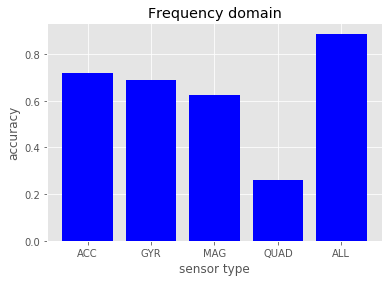

In [ ]:
x = ['ACC', 'GYR', 'MAG', 'QUAD','ALL']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy,ALL_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='blue')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("Frequency domain")

plt.xticks(x_pos, x)

plt.show()

In [33]:
df_accuracy.to_csv('D:\projec\proj\data\Frequency_domain_accuracy.csv', index=False)